In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('data/field_data.csv')

# Display the first few rows of the DataFrame
df.head()


,prng,prow,expt,identity1.x,checks,Test,Location,Year,Loc_Year_test,MM_CA,...,T3_991,T3_992,T3_993,T3_994,T3_995,T3_996,T3_997,T3_998,T3_999,T3_1000
0,2,72,20-B-307,LD11-2170,17,B,CAD,2020,2020_B_CAD,1632.500,...,1.828294,1.783840,1.834939,1.812549,1.819246,1.838368,1.840609,1.801353,1.771047,1.676648
1,2,71,20-B-307,A16351-79,0,B,CAD,2020,2020_B_CAD,1641.333,...,1.300773,1.267140,1.228918,1.243922,1.296724,1.299482,1.291595,1.193926,1.263729,1.237707
2,2,70,20-B-307,A16355-73,0,B,CAD,2020,2020_B_CAD,1675.500,...,0.826375,0.744380,0.778770,0.738044,0.786527,0.800620,0.770696,0.759226,0.767577,0.749865
3,3,72,20-B-307,A16355-174,0,B,CAD,2020,2020_B_CAD,1679.000,...,0.912524,0.833673,0.894313,0.890009,0.883864,0.908583,0.911078,0.946643,0.931860,0.847279
4,3,71,20-B-307,A16355-204,0,B,CAD,2020,2020_B_CAD,1683.889,...,1.083679,1.016247,1.057040,1.080130,1.105700,1.035190,1.035056,1.025193,1.039471,1.032454


In [6]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

# Extract the spatial information and reflectance values
spatial_data = df[['prng', 'prow']].values
reflectance_data = df.filter(like='T3_').values

# Define a threshold for spatial proximity (this can be adjusted based on the data distribution)
spatial_threshold = np.percentile(euclidean_distances(spatial_data), 10)  # Using 10th percentile as an example

# Compute pairwise distances for spatial data
spatial_distances = euclidean_distances(spatial_data)

# Create an adjacency matrix based on spatial proximity
adjacency_matrix_spatial = (spatial_distances < spatial_threshold).astype(int)

# Compute cosine similarities for reflectance data
reflectance_similarities = cosine_similarity(reflectance_data)

# Define a threshold for reflectance similarity (e.g., 0.95)
reflectance_threshold = 0.95

# Create an adjacency matrix based on reflectance similarity
adjacency_matrix_reflectance = (reflectance_similarities > reflectance_threshold).astype(int)

# Combine the adjacency matrices (logical OR operation)
combined_adjacency = np.logical_or(adjacency_matrix_spatial, adjacency_matrix_reflectance).astype(int)

# Ensure the diagonal of the combined adjacency matrix is zero (no self-loops)
np.fill_diagonal(combined_adjacency, 0)

combined_adjacency


array([[0, 1, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0]])

In [7]:
# Extract the features for the nodes (soil health indicators + reflectance values)
feature_columns = ['MM_CA', 'MM_CEC', 'MM_K', 'MM_MG', 'MM_OM', 'MM_P1', 'MM_PH', 'MM_CLAY', 'MM_SAND', 'MM_SILT']
features = df[feature_columns + list(df.filter(like='T3_').columns)].values

# Normalize the features for better convergence during training
features_normalized = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

features_normalized


array([[-1.80099083, -1.58360611,  0.11621681, ...,  1.73655981,
         1.5206789 ,  1.38288076],
       [-1.79032858, -1.52438907,  0.05553034, ...,  0.06100066,
         0.16827971,  0.19876071],
       [-1.74908583, -1.40595497, -0.1437938 , ..., -1.13809991,
        -1.15435309, -1.11727969],
       ...,
       [ 2.79589717,  2.06653267,  0.99973285, ..., -1.12123996,
        -0.99704342, -1.27228889],
       [ 2.79607823,  2.30576954,  1.08293625, ..., -1.57346083,
        -1.63275912, -1.53463452],
       [ 2.79642829,  2.31998163,  1.885849  , ...,  0.60470013,
         0.90757836,  1.22947479]])

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GNN, self).__init__()
        
        # Graph convolutional layers
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Graph convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

# Define the model with initial dimensions
num_features = features_normalized.shape[1]
hidden_dim = 64  # This can be adjusted based on experimentation
output_dim = 1  # Since we are doing regression for yield prediction

model = GNN(num_features, hidden_dim, output_dim)

# Assuming model is already defined with the same architecture
model.load_state_dict(torch.load('gnn_model.pth'))
model.eval()  # Set the model to evaluation mode



ModuleNotFoundError: No module named 'torch_geometric'

In [10]:
# Save the model's state dictionary
# torch.save(model.state_dict(), 'gnn_model.pth')


In [11]:
# Convert the features and adjacency matrix to PyTorch tensors
x = torch.tensor(features_normalized, dtype=torch.float)
edge_index = torch.tensor(np.where(combined_adjacency == 1))

# Convert yield values to PyTorch tensor
y = torch.tensor(df["Yield"].values, dtype=torch.float).view(-1, 1)

# Create a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)


C:\Users\gupta\AppData\Local\Temp\ipykernel_4308\2654023027.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  edge_index = torch.tensor(np.where(combined_adjacency == 1))


In [7]:
# # Define the optimizer and loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# num_epochs = 100  # Adjust as needed
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out, data.y)
#     loss.backward()
#     optimizer.step()
#     print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 4717.64501953125
Epoch 2, Loss: 4671.76025390625
Epoch 3, Loss: 4538.8271484375
Epoch 4, Loss: 4271.82080078125
Epoch 5, Loss: 3810.993896484375
Epoch 6, Loss: 3096.499755859375
Epoch 7, Loss: 2102.22998046875
Epoch 8, Loss: 1039.3958740234375
Epoch 9, Loss: 511.005615234375
Epoch 10, Loss: 1464.127197265625
Epoch 11, Loss: 1504.3907470703125
Epoch 12, Loss: 834.5032958984375
Epoch 13, Loss: 394.11224365234375
Epoch 14, Loss: 348.07354736328125
Epoch 15, Loss: 476.01220703125
Epoch 16, Loss: 620.6856079101562
Epoch 17, Loss: 674.9942016601562
Epoch 18, Loss: 600.8381958007812
Epoch 19, Loss: 482.6234436035156
Epoch 20, Loss: 328.2270812988281
Epoch 21, Loss: 229.04400634765625
Epoch 22, Loss: 243.4249725341797
Epoch 23, Loss: 371.162353515625
Epoch 24, Loss: 432.2864074707031
Epoch 25, Loss: 392.0430603027344
Epoch 26, Loss: 314.3330078125
Epoch 27, Loss: 234.82095336914062
Epoch 28, Loss: 234.4933319091797
Epoch 29, Loss: 274.4092102050781
Epoch 30, Loss: 325.5440063476

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert adjacency matrix to a NetworkX graph
G = nx.from_numpy_array(combined_adjacency)

# pos = nx.kamada_kawai_layout(G)
# plt.figure(figsize=(10, 10))
# nx.draw_networkx_nodes(G, pos, node_size=20, node_color="skyblue")
# nx.draw_networkx_edges(G, pos, edge_color="gray")
# plt.title("Graph constructed from Soil Data")
# plt.axis("off")
# plt.show()


ImportError: cannot import name 'cbook' from partially initialized module 'matplotlib' (most likely due to a circular import) (C:\Users\gupta\anaconda3\lib\site-packages\matplotlib\__init__.py)

In [21]:
# def extract_simple_subgraph(G, num_nodes=100):
#     """
#     Extract a subgraph from the main graph by randomly selecting a subset of nodes.
    
#     Parameters:
#     - G: The main graph.
#     - num_nodes: Number of nodes to randomly select.
    
#     Returns:
#     - A subgraph of G.
#     """
#     # Randomly select nodes
#     random_nodes = np.random.choice(G.nodes(), size=num_nodes, replace=False)
    
#     # Extract subgraph
#     return G.subgraph(random_nodes)

def extract_small_subgraph(G, num_nodes=50):
    random_nodes = np.random.choice(list(G.nodes()), size=num_nodes, replace=False)
    return G.subgraph(random_nodes)

subG = extract_small_subgraph(G)

# Use the most basic layout
pos_sub = nx.shell_layout(subG)

plt.figure(figsize=(10, 10))
nx.draw(subG, pos=pos_sub, node_size=20, node_color="skyblue", edge_color="gray")
plt.title("Subgraph from Soil Data")
plt.show()


TypeError: '_AxesStack' object is not callable

<Figure size 1000x1000 with 0 Axes>

In [15]:
# Evaluate the model and get predictions
model.eval()
with torch.no_grad():
    predictions = model(data)

# Extract predictions for specific nodes (e.g., the first 100 nodes)
true_values = data.y.numpy()[:10]
predicted_values = predictions.numpy()[:10]

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predicted_values, alpha=0.6)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--')
plt.xlabel("True Yield Values")
plt.ylabel("Predicted Yield Values")
plt.title("True vs Predicted Yield for Selected Nodes")
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

C:\Users\gupta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\gupta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


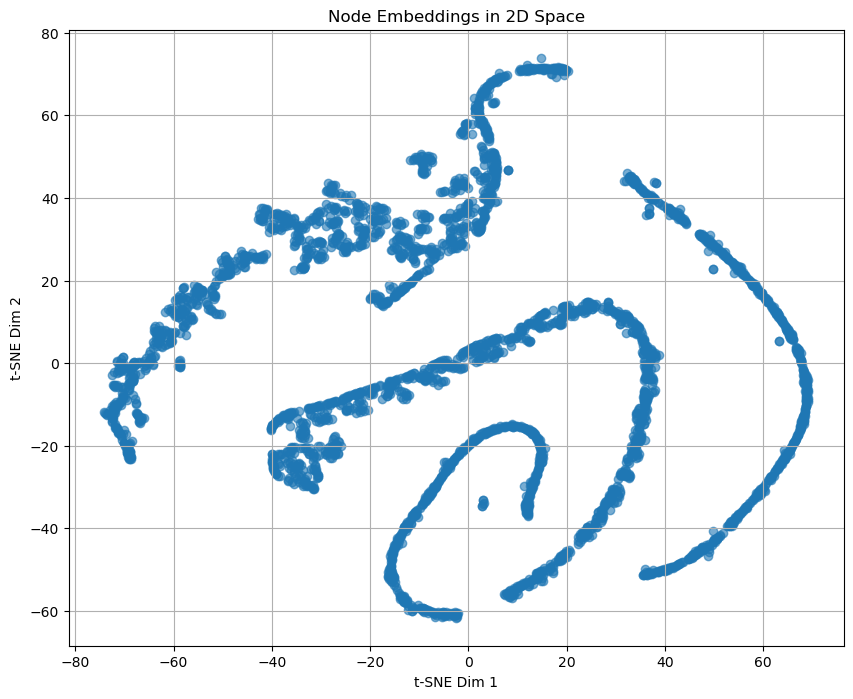

In [10]:
from sklearn.manifold import TSNE

# Extract embeddings (features after graph convolutions but before fully connected layers)
def get_embeddings(data):
    x, edge_index = data.x, data.edge_index
    x = model.conv1(x, edge_index)
    x = F.relu(x)
    x = model.conv2(x, edge_index)
    return x.detach().numpy()

embeddings = get_embeddings(data)

# Use t-SNE for dimensionality reduction
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], alpha=0.6)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("Node Embeddings in 2D Space")
plt.grid(True)
plt.show()


In [17]:
!pip install matplotlib
import matplotlib.pyplot as plt


  Using cached matplotlib-3.7.2-cp39-cp39-win_amd64.whl (7.5 MB)


R^2 Score: -0.03358256816864014


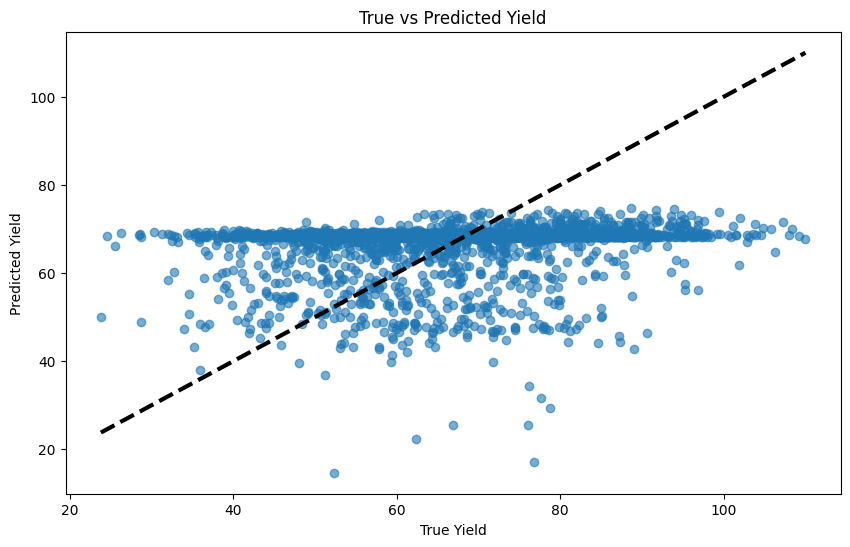

In [18]:
import numpy as np

# 1. Predict the outputs using the model
with torch.no_grad():
    predictions = model(data)

# Convert predictions and true values to numpy for calculations and plotting
y_true = y.cpu().numpy()
y_pred = predictions.cpu().numpy()

# 2. Calculate the R^2 value
mean_y_true = y_true.mean()
ss_res = ((y_true - y_pred) ** 2).sum()
ss_tot = ((y_true - mean_y_true) ** 2).sum()
r2_score = 1 - (ss_res / ss_tot)

print(f"R^2 Score: {r2_score}")

# 3. Plot the true versus predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title('True vs Predicted Yield')
plt.show()
